In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
import numpy as np
from sklearn.datasets import load_iris, make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split
from scipy.linalg import eigh
from math import inf

from sklearn.metrics.pairwise import polynomial_kernel

from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


from sklearn.linear_model import LogisticRegression

In [57]:
def plot_decision_boundary(X, y, model):
    h = .02
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    all_data = np.c_[xx.ravel(), yy.ravel()]
    
    Z = np.array(model.predict(all_data))
    Z = Z.reshape(xx.shape)    
    
    # Put the result into a color plot
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    plt.scatter(X[:, 0], X[:, 1], c = y) 
    plt.show()
    
# Define different kernels

class linear_kernel:
    def run(self, x, y):
        return(np.dot(x.T, y))

class poly_kernel:
    def __init__(self, c0=1, d=3, gamma = None):
        self.c0 = c0
        self.d = d
        self.gamma = gamma
        
    def run(self, x, y):
        if (self.gamma == None):
            self.gamma = 1 / x.size
            
        return((self.gamma * np.dot(x.T, y) + self.c0) ** self.d)
    
class sigmoid_kernel:
    def __init__(self, c0=1, gamma=None):
        self.c0 = c0
        self.gamma = gamma
        
    def run(self, x, y):
        if (self.gamma == None):
            self.gamma = 1 / x.size
            
        return(np.tanh(self.gamma * np.dot(x.T, y) + self.c0))
        
class rbf_kernel:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def run(self, x, y):
        delta =abs(np.subtract(x, y))
        squaredEuclidean = (np.square(delta).sum())
        result = np.exp(-(squaredEuclidean)/(2*self.sigma**2))
        return result
    
    
def get_gram_matrix(kernel, X):
    K = np.zeros((X.shape[0], X.shape[0]))
    
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            K[i][j] = kernel.run(X[i], X[j])
    return(K)


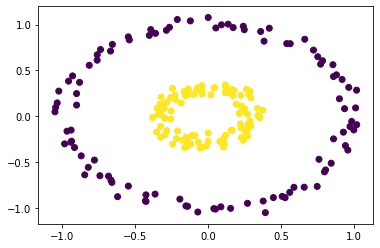

In [4]:
# X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state = 3, n_clusters_per_class=1, class_sep = 3)
# X, y = make_moons(n_samples = 200, noise = 0.005, random_state = 417) 
X, y = make_circles(n_samples = 200, noise = 0.05, random_state = 417, factor=0.3) 
y[y == 0] = -1

plt.scatter(X[:, 0], X[:, 1], c = y) 
plt.show()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# Sci-kit learn Logistic Regression

In [ ]:
logisticRegr = LogisticRegression(fit_intercept=False, penalty='l2')
logisticRegr.fit(X_train, y_train)

In [ ]:
score = logisticRegr.score(X_test, y_test)
print(score)

In [ ]:
predicted = logisticRegr.predict(X_test)
print(classification_report(y_test, predicted))

In [ ]:
plot_decision_boundary(X, y, logisticRegr)

# Kernel Logistic Regression

In [35]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KernelLogisticRegression(BaseEstimator, ClassifierMixin):
    
    def __init__(self, krn="rbf", lr=0.01, num_iter=100, lmbda=1, c0=1, d=3, gamma=0.5, sigma=5):
        self.lr = lr
        self.num_iter = num_iter
        self.lmbda = lmbda
        self.krn = krn
        self.c0 = c0
        self.d = d
        self.gamma = gamma
        self.sigma = sigma
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def __P_i(self, z):
        return -self.__sigmoid(-z)
    
    def fit(self, X, y):
        # weights initialization
        self.X = X
        
        if (self.krn == "rbf"):
            self.kernel = rbf_kernel(self.sigma)
        if (self.krn == "linear"):
            self.kernel = linear_kernel()
        if (self.krn == "poly"):
            self.kernel = poly_kernel(self.c0, self.d, self.gamma)
        if (self.krn == "sigmoid"):
            self.kernel = sigmoid_kernel(self.c0, self.gamma)
        
        K = get_gram_matrix(self.kernel, X)
        self.alfa = np.zeros(K.shape[1])
        
        for i in range(self.num_iter):
            
            yKAlfa = np.multiply(y, np.dot(K, self.alfa))
            P = self.__P_i(yKAlfa)
            P = np.diag(P)

            gradient = (np.dot(np.matmul(K, P), y)) / y.size + self.lmbda * np.dot(K, self.alfa)
            self.alfa -= self.lr * gradient
            
    
    def predict(self, x):
        results = []
        
        for j in range(x.shape[0]):
            s = 0
            
            for i in range(self.X.shape[0]):
                s += self.alfa[i] * self.kernel.run(self.X[i], x[j])
        
            if self.__sigmoid(s) >= 0.5:
                results.append(1)
            else:
                results.append(-1)
        
        return results
            
        
        
    def score(self, X, y=None):
        # counts number of values bigger than mean
        return (self.predict(X) == y).mean()
        


In [61]:
kernel_model = KernelLogisticRegression(krn="rbf", sigma=0.5, lr=0.001, num_iter=10000, lmbda=1)
kernel_model.fit(X_train, y_train)

In [62]:
kernel_model.score(X_test, y_test)

1.0

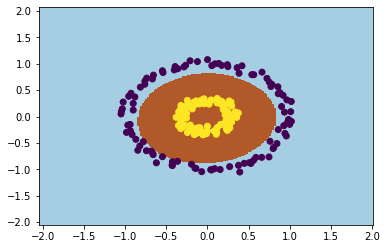

In [63]:
plot_decision_boundary(X, y, kernel_model)

In [39]:

# Set the parameters by cross-validation
tuned_parameters = [{'krn': ['rbf'], 'lr': [0.1, 0.01, 0.001, 0.0001], 'sigma': [0.01 0.1, 0.5, 1, 10], 'lmbda': [0.01, 0.1, 1, 2, 3]},
                    {'krn': ['poly'], 'lr': [1e-3, 1e-4], 'gamma': [0.1, 1, 2, 3, 4], 'd': [2, 3, 4, 5]}]

scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(KernelLogisticRegression(), tuned_parameters, cv=5,
                       scoring='%s' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for accuracy



/home/andrei/ml/env/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/home/andrei/ml/env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'d': 5, 'gamma': 1, 'krn': 'poly', 'lr': 0.001}

Grid scores on development set:

0.470 (+/-0.019) for {'krn': 'rbf', 'lr': 0.001, 'sigma': 1}
0.530 (+/-0.019) for {'krn': 'rbf', 'lr': 0.001, 'sigma': 10}
0.530 (+/-0.019) for {'krn': 'rbf', 'lr': 0.001, 'sigma': 100}
0.530 (+/-0.019) for {'krn': 'rbf', 'lr': 0.001, 'sigma': 1000}
0.470 (+/-0.019) for {'krn': 'rbf', 'lr': 0.0001, 'sigma': 1}
0.530 (+/-0.019) for {'krn': 'rbf', 'lr': 0.0001, 'sigma': 10}
0.530 (+/-0.019) for {'krn': 'rbf', 'lr': 0.0001, 'sigma': 100}
0.530 (+/-0.019) for {'krn': 'rbf', 'lr': 0.0001, 'sigma': 1000}
0.530 (+/-0.019) for {'d': 2, 'gamma': 0.1, 'krn': 'poly', 'lr': 0.001}
0.530 (+/-0.019) for {'d': 2, 'gamma': 0.1, 'krn': 'poly', 'lr': 0.0001}
0.530 (+/-0.019) for {'d': 2, 'gamma': 1, 'krn': 'poly', 'lr': 0.001}
0.530 (+/-0.019) for {'d': 2, 'gamma': 1, 'krn': 'poly', 'lr': 0.0001}
0.552 (+/-0.046) for {'d': 2, 'gamma': 2, 'krn': 'poly', 'lr': 0.001}
0.530 (+/-